In [84]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from matplotlib import animation, rc
from IPython.display import HTML
from numba import jit

In [2]:
angle_range = np.linspace(0,2*np.pi,1000)
line_range = np.linspace(-1.0, 1.0, 1000)
circle_x = np.cos(angle_range)
circle_y = np.sin(angle_range)
circle_z = np.zeros_like(angle_range)

circle_3d = np.vstack((circle_x, circle_y, circle_z))
circle_3d.shape

(3, 1000)

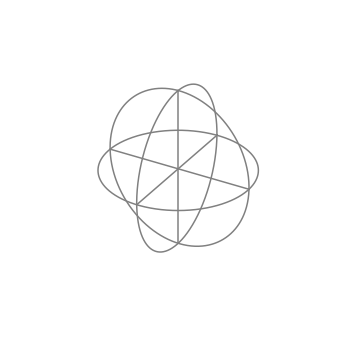

In [3]:
fig = plt.figure(figsize=(6,6))# (figsize=(7.5,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')
ax.set_axis_off()
plt.plot(circle_x, circle_y, circle_z, color='gray')
plt.plot(circle_z, circle_x, circle_y, color='gray')
plt.plot(circle_y, circle_z, circle_x, color='gray')
plt.plot(line_range, circle_z, circle_z, color='gray')
plt.plot(circle_z, line_range, circle_z, color='gray')
plt.plot(circle_z, circle_z, line_range, color='gray')
plt.ioff()
plt.show()

In [4]:
def init_bloch_sphere():
    fig = plt.figure(figsize=(6,6))# (figsize=(7.5,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_aspect('equal')
    ax.set_axis_off()
    plt.plot(circle_x, circle_y, circle_z, color='gray')
    plt.plot(circle_z, circle_x, circle_y, color='gray')
    plt.plot(circle_y, circle_z, circle_x, color='gray')
    plt.plot(line_range, circle_z, circle_z, color='gray')
    plt.plot(circle_z, line_range, circle_z, color='gray')
    plt.plot(circle_z, circle_z, line_range, color='gray')
    
    return fig, ax

def spher_to_cart(theta, phi, r=1.0):
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z

def plot_vector(x, y, z, **kw):
    line = plt.plot([0.0, x], [0.0, y], [0.0, z], **kw)
    dot = plt.plot([x], [y], [z], marker='o', zorder=1000, **kw)
    return line, dot
    
def plot_vector_sph(theta, phi, **kw):
    r = kw.pop('r', 1.0)
    plot_vector(*spher_to_cart(theta, phi, r), **kw)

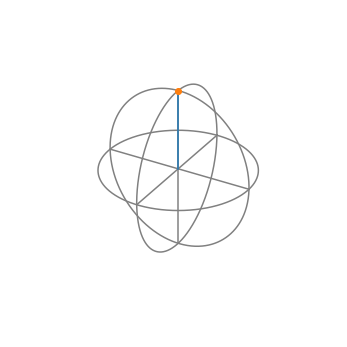

In [5]:
fig, ax = init_bloch_sphere()
plot_vector_sph(0.0,-np.pi/2)

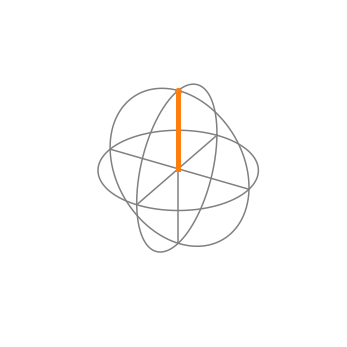

In [6]:
fig, ax = init_bloch_sphere()

(line,) = plt.plot([], [], [], color='C1', animated=True, linewidth=5)
(dot,) = plt.plot([], [], [], marker='o', zorder=1000, color='C1')

def general_update(theta, phi):
    x, y, z = spher_to_cart(theta, phi)
    line.set_data([0.0, x], [0.0, y])
    line.set_3d_properties([0.0, z])
    dot.set_data([x], [y])
    dot.set_3d_properties([z])
    
ani = animation.FuncAnimation(fig, lambda t: general_update(t, -np.pi/2), frames=np.linspace(0, np.pi, 100), interval=20)

ani.save("simple-pi.mp4")

from IPython.display import HTML
HTML(ani.to_jshtml())

## Numerical integration of Hamiltonians

In [121]:
sx = np.array([[0, 1],  [ 1, 0]], dtype=np.complex128)
sy = np.array([[0, -1j],[1j, 0]], dtype=np.complex128)
sz = np.array([[1, 0],  [0, -1]], dtype=np.complex128)
si = np.array([[1, 0],  [ 0, 1]], dtype=np.complex128)
S = np.stack((sx, sy, sz), axis=0)

def x(t):
    return np.zeros_like(t)

def y(t):
    return np.zeros_like(t)

def z(t):
    return np.ones_like(t) * 0.5

def calc_ev_ops(H_pauli, dt):
    N = H_pauli.shape[0]
    # we expect the hamiltonian in pauli-decomposed form [x, y, z]
    
    H_norms = np.linalg.norm(H_pauli, axis=1).reshape(-1, 1)
    angles = H_norms * dt
    
    H_pauli_normed = H_pauli / H_norms
    # is h_norm is 0, we get infinities
    # but in that case the rotation angle h_norm * dt is also zero
    # so we don't really care about the rotation axis and we can set
    # the infinities to zero
    H_pauli_normed[np.isinf(H_pauli_normed)] = 0.0 
    R_matrix = np.tensordot(H_pauli_normed, S, axes=([1], [0]))
    
    eyes = np.repeat(np.eye(2)[np.newaxis,:,:], N, axis=0)
    
    ev_ops = np.cos(angles).reshape(-1, 1, 1) * eyes + 1j * np.sin(angles).reshape(-1, 1, 1) * R_matrix
    
    return ev_ops

@jit(nopython=True)
def accumulate_ev_ops(ev_ops):
    N = ev_ops.shape[0]
    
    # complicated way of getting the dtype right for np.eye,
    # apparently, numba doesn't support the dtype parameter for np.eye
    acc_op = np.zeros((2,2), dtype=np.complex128)
    acc_op[:,:] += np.eye(2)
    
    for i in range(N):
        acc_op = np.dot(acc_op, ev_ops[i,:,:])
        
    return acc_op

@jit(nopython=True)
def accumulate_ev_ops_over_state(ev_ops, state):
    N = ev_ops.shape[0]
    result = np.zeros((N, 2), dtype=np.complex128)

In [122]:
test = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [1, 1, 0],
    [1, 1, 1],
    [3, 3, 0],
], dtype=np.double)

In [125]:
ts = np.linspace(0,4*np.pi, int(1e4))
dt = np.diff(ts)[0]
H_pauli = np.zeros((len(ts), 3))
H_pauli[:,0] = x(ts)
H_pauli[:,1] = y(ts)
H_pauli[:,2] = z(ts)

ev_ops = calc_ev_ops(H_pauli, dt)
acc_ev_op = accumulate_ev_ops(ev_ops)

In [98]:
acc_ev_op

array([[  3.06161700e-16+1.j,   0.00000000e+00+0.j],
       [  0.00000000e+00+0.j,   3.06161700e-16-1.j]])

In [79]:
np.tensordot(test, S, axes=([1], [0]))

array([[[ 3.+0.j,  1.-2.j],
        [ 1.+2.j, -3.+0.j]],

       [[ 6.+0.j,  4.-5.j],
        [ 4.+5.j, -6.+0.j]],

       [[ 0.+0.j,  1.-1.j],
        [ 1.+1.j,  0.+0.j]],

       [[ 1.+0.j,  1.-1.j],
        [ 1.+1.j, -1.+0.j]],

       [[ 0.+0.j,  3.-3.j],
        [ 3.+3.j,  0.+0.j]]])

In [22]:
test = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [1, 1, 0],
    [1, 1, 1],
    [3, 3, 0],
], dtype=np.double)

In [23]:
testnorm = np.linalg.norm(test, axis=1)

In [35]:
np.divide(test, testnorm.reshape(5,1))

array([[ 0.26726124,  0.53452248,  0.80178373],
       [ 0.45584231,  0.56980288,  0.68376346],
       [ 0.70710678,  0.70710678,  0.        ],
       [ 0.57735027,  0.57735027,  0.57735027],
       [ 0.70710678,  0.70710678,  0.        ]])

In [28]:
np.divide?

In [37]:
testnorm = np.linalg.norm(test, axis=1)

In [38]:
np.divide(test, testnorm.reshape(-1,1))

array([[ 0.26726124,  0.53452248,  0.80178373],
       [ 0.45584231,  0.56980288,  0.68376346],
       [ 0.70710678,  0.70710678,  0.        ],
       [ 0.57735027,  0.57735027,  0.57735027],
       [ 0.70710678,  0.70710678,  0.        ]])

In [56]:
np.repeat(np.eye(2)[np.newaxis, :, :], 3, axis=0)

array([[[ 1.,  0.],
        [ 0.,  1.]],

       [[ 1.,  0.],
        [ 0.,  1.]],

       [[ 1.,  0.],
        [ 0.,  1.]]])

TypeError: object of type 'int' has no len()

## Lab frame with axes

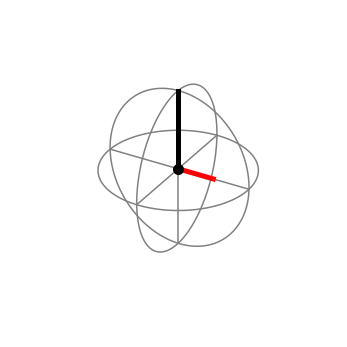

In [7]:
# physical parameters
w_0 = 1.0        # S_z qubit frequency
w_R = 0.0        # rotating frame frequency
w_D = 1.0        # drive frequency
H_1 = 0.5        # drive strength (static for now) in units of H_1/w_0 (i.e. w_0 is scaled to 1)

# plot parameters
axis_width = 5     # line width of the plotted precession axes
qubit_width = 2    # line width of the qubit state vector

fig, ax = init_bloch_sphere()

# define plot elements
# static magnetic field precession axis
(w_0_line,) = plt.plot([], [], [], color='k', animated=True, linewidth=axis_width)
(w_0_dot,) = plt.plot([0.0], [0.0], [0.0], color='k', animated=True, marker='o', markersize=2*axis_width, linestyle='', zorder=1000)
# drive field precession axis
(w_D_line,) = plt.plot([], [], [], color='r', animated=True, linewidth=axis_width)
# qubit state vector
(qb_line,) = plt.plot([], [], [], color='g', animated=True, linewidth=qubit_width)

def spher_to_cart_rotating_frame(theta, phi, r=1.0, rot_phase=0.0):
    x = r * np.sin(theta) * np.cos(phi - rot_phase)
    y = r * np.sin(theta) * np.sin(phi - rot_phase)
    z = r * np.cos(theta)
    return np.array([x, y, z])

def update_line(line, c):
    line.set_data([0.0, c[0]], [0.0, c[1]])
    line.set_3d_properties([0.0, c[2]])
    line.set_zorder(-c[1]+100)

def update(t):
    # update the plot for a new frame at time t
    # first we calculate all coordinates in spherical coordinates (to facilitate the rotating frame transformation)
    # [theta, phi, r]
    w_0_angles = [0.0, 0.0, 1.0]
    w_D_angles = [np.pi / 2, w_D * t, H_1]
    
    # apply rotating frame transformation and convert to cartesian coords for plotting
    rotating_frame_phase = w_R * t
    w_0_coords = spher_to_cart_rotating_frame(*w_0_angles, rot_phase=rotating_frame_phase)
    w_D_coords = spher_to_cart_rotating_frame(*w_D_angles, rot_phase=rotating_frame_phase)
    
    # update plot
    update_line(w_0_line, w_0_coords)
    update_line(w_D_line, w_D_coords)
    
ani = animation.FuncAnimation(fig, update, frames=np.linspace(0, 2*np.pi, 100), interval=20)

HTML(ani.to_jshtml())